In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
import math

from scipy import stats


In [2]:
np.random.seed(75)

In [3]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [4]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#FFD800', # 7 # School Bus Yellow
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


* `x` : The global x range

In [5]:
x = np.linspace(0, 4, 1000)

In [28]:
def getArea(dist, x, *args):
    # REPRODUCIBILITY!
    np.random.seed(75)

    # consistently use this energy range 
    x_min = x.min()
    x_max = x.max()

    y = dist(x, *args)
    y_min = 1e-10
    y_max = y.max()
    
    # Check if y_max is too large and handle it
    if y_max > 1e308:  # This is close to the max float
        print("y_max is too large, might cause overflow")
        return None

    N = 100_000
    x_random = np.random.uniform(x_min, x_max, N)
    y_random = np.random.uniform(y_min, y_max, N)
    y_random = y_random[y_random < dist(x_random, *args)]
    accepted = len(y_random)
    area = (x_max - x_min) * (y_max - y_min) * accepted / N
    return area

* likelihood : gamma

In [49]:
def gammaCore(x, alpha, beta):
    return beta**alpha/math.gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)
print(getArea(gammaCore, x, 1, 0.2))
print(getArea(gammaCore, x, 1, 10))


0.551327999724336
0.978399999990216


NameError: name 'gammaDist' is not defined

In [50]:
def gammaDist(x):
    alpha = 2.0
    beta = 2.0
    return gammaCore(x, alpha, beta)
gamma_nomaliser = getArea(gammaDist, x)

def gammaPdf(x):
    alpha = 2.0
    beta = 2.0
    return gammaCore(x, alpha, beta)/ gamma_nomaliser
print(f'{getArea(gammaPdf, x):.3f}')

1.000


* Prior

In [21]:
def priorPdf(x):
    N = 1.6 + 2.66*(2.1-1.6)
    value = np.ones_like(x)*1e-10
    # value[x < 0.0] = 0.0
    value[(x >= 0.0) & (x < 1.6)] = 1.0 / N
    value[(x >= 1.6) & (x < 2.1)] = 2.66 / N
    # value[x >= 2.1] = 0.0

    return value
print(f'{getArea(priorPdf, x):.3f}')

In [45]:
def likelihood_prior(_x):
    return gammaPdf(_x)*priorPdf(_x)
posterior_normaliser = getArea(likelihood_prior, x)

def posteriorPdf(x):
    return likelihood_prior(x) / posterior_normaliser
print(f'{getArea(posteriorPdf, x):.3f}')

1.000


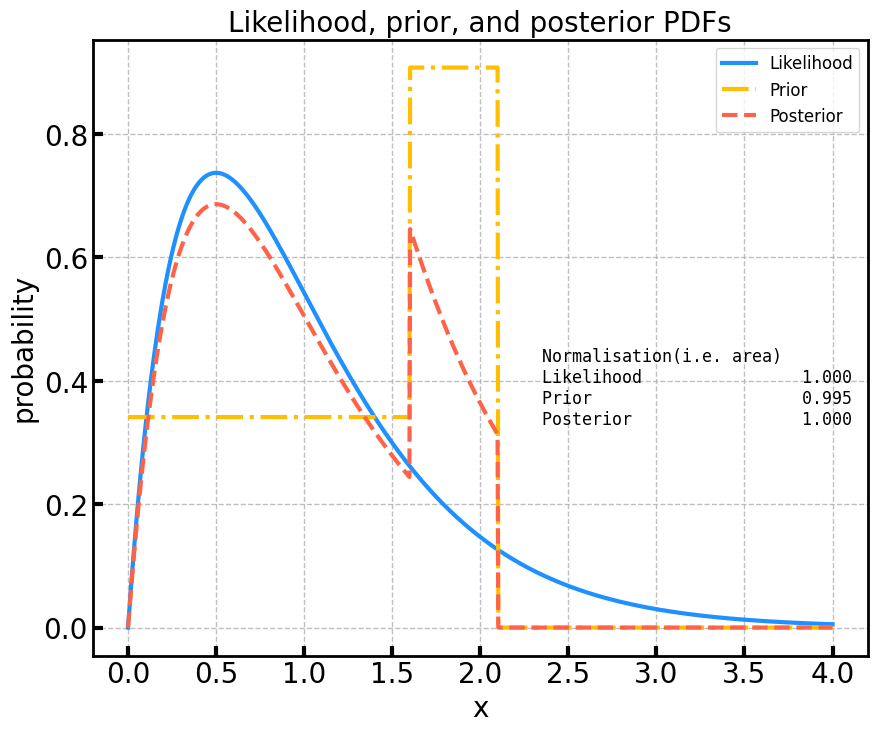

In [23]:
def plotPDFs(*pdfs, labels=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    for i, pdf in enumerate(pdfs):
        label = labels[i] if labels and i < len(labels) else pdf.__name__
        ax.plot(x, pdf(x), label=label, marker = '', lw=3)
    ax.set_xlabel('x')
    ax.set_ylabel('probability')
    ax.set_title('Likelihood, prior, and posterior PDFs')
    ax.legend()
    d = {'Normalisation(i.e. area)': '',}
    for i, pdf in enumerate(pdfs):
        d[f'{labels[i]}'] = f'{getArea(pdf, x):.3f}'
    nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.58, 0.5, nice_string_output(d, extra_spacing=2, decimals=3), ax, fontsize=12)

    plt.show()
plotPDFs(gammaPdf, priorPdf, posteriorPdf, labels=['Likelihood', 'Prior', 'Posterior'])

In [24]:
def findLocalMax(bound):
    print(f'-------- {bound[0]} < x < {bound[1]} --------')
    p_whole = posteriorPdf(x)
    mask = (x >= bound[0]) & (x <= bound[1])
    x_filtered = x[mask]
    p_filtered = p_whole[mask]
    max_i = np.argmax(p_filtered)
    max_x = x_filtered[max_i]
    max_p = p_filtered[max_i]
    deltax = x_filtered[1] - x_filtered[0]
    print(f'The local max x is at: {max_x:.3f}')
    print(f'With posterior PDF value of: {max_p:.3f}')
    print(f'And the uncertainty is: {deltax:.3f}')


findLocalMax((0.3,0.7))
findLocalMax((1.5,2.0))

-------- 0.3 < x < 0.7 --------
The local max x is at: 0.501
With posterior PDF value of: 0.686
And the uncertainty is: 0.004
-------- 1.5 < x < 2.0 --------
The local max x is at: 1.602
With posterior PDF value of: 0.646
And the uncertainty is: 0.004


In [25]:
def meanPosterior(N):
    x = np.linspace(0, 4, N)
    p_whole = posteriorPdf(x)
    normalisation = sum(p_whole)
    mean = sum(x_i * p_i for x_i, p_i in zip(x, p_whole)) / normalisation
    print(f'N = {N} & {mean:.3f} & {normalisation:.3f}')
    return mean
    
meanPosterior(100)        
meanPosterior(1_000)
meanPosterior(10_000)
mean = meanPosterior(100_000)


N = 100 & 0.990 & 24.744
N = 1000 & 0.995 & 250.930
N = 10000 & 0.995 & 2511.139
N = 100000 & 0.995 & 25113.213


In [52]:
def getPosterior_mean(mean):
    print(f'Posterior mean: {posteriorPdf(mean):.3f}')
getPosterior_mean(mean)

Posterior mean: 0.508


In [15]:
def meanPosteriorF(N, f):
    x = np.linspace(0, 4, N)
    p_whole = posteriorPdf(x)
    normalisation = sum(p_whole)
    mean = sum(f(x_i) * p_i for x_i, p_i in zip(x, p_whole)) / normalisation
    print(f'N = {N} & {mean:.3f} & {normalisation:.3f}')

meanPosteriorF(100, np.cos)
meanPosteriorF(100, np.sin)
meanPosteriorF(100, np.exp)
# meanPosteriorF(100, stats.gamma.pdf())

N = 100 & 0.470 & 24.744
N = 100 & 0.702 & 24.744
N = 100 & 3.175 & 24.744


In [16]:
def reflectPosteriorPdf(x):
    return -posteriorPdf(x)

In [17]:
def plotReflection():
    fig, ax = plt.subplots(figsize=(10, 8))
#     ax.axhline(0, color='black', lw=1)
#     ax.plot(x, posteriorPdf(x), c = COLOUR[2], 
#             label='Posterior', marker = '', lw=3)
    ax.plot(x, reflectPosteriorPdf(x), c = COLOUR[3], 
            label='Reflected Posterior', marker = '', lw=3)
    ax.set_xlabel('x')
    ax.set_ylabel('-probability')
    ax.set_title('Reflected posterior PDFs')
    ax.legend()
    plt.show()
    print(f'Max of reflected posterior: {reflectPosteriorPdf(x).max()}')
    print(f'Min of reflected posterior: {reflectPosteriorPdf(x).min()}')
    print(f'x of Max of reflected posterior: {x[reflectPosteriorPdf(x).argmax()]}')
    print(f'x of Min of reflected posterior: {x[reflectPosteriorPdf(x).argmin()]}')
# plotReflection()